# **🎬 Movie Recommendation System**

## **Step 1: Setup and configuration**

In [22]:
!pip install pyspark==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 12.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=6e58b0d14984a7f1bb0944855e7fd8fcd267176d52241fd52180c135e35c1e44
  Stored in directory: /root/.cache/pip/wheels/84/40/20/65eefe766118e0a8f8e385cc3ed6e9eb7241c7e51cfc04c51a
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9
  Attempting uninstall: pyspark
    Found existing installation: pyspark 4.0.1
    Uninstalling pyspark-4.0.1:
      Successfully uninstalled pyspark-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-conn

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, ArrayType
from pyspark.sql.functions import udf, from_unixtime, year, month
import ast
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [24]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Initialize Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("MovieRecommendationSystem") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()
spark

In [26]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [27]:
# Define paths
RAW_PATH = "/content/drive/MyDrive/movie-reco/raw"
CLEAN_PATH = "/content/drive/MyDrive/movie-reco/clean"
VIZ_PATH = f"{CLEAN_PATH}/visualizations"

print("\nMOVIE RECOMMENDATION SYSTEM - DATA PROCESSING PIPELINE")
print(f"Spark Version: {spark.version}")
print(f"Raw Data Path: {RAW_PATH}")
print(f"Clean Data Path: {CLEAN_PATH}\n")


MOVIE RECOMMENDATION SYSTEM - DATA PROCESSING PIPELINE
Spark Version: 3.5.0
Raw Data Path: /content/drive/MyDrive/movie-reco/raw
Clean Data Path: /content/drive/MyDrive/movie-reco/clean



In [28]:
def time_operation(operation_name, func):
    """Time a function execution and print results"""
    print(f"\nStarting: {operation_name}")
    start = time.time()
    result = func()
    elapsed = time.time() - start
    print(f"Completed: {operation_name} in {elapsed:.2f}s")
    return result


def data_quality_report(df, name):
    """Generate comprehensive data quality report"""
    print(f"\nDATA QUALITY REPORT: {name}")

    total = df.count()
    print(f"Total rows: {total:,}")
    print(f"Total columns: {len(df.columns)}")

    print(f"\nMissing Values Analysis:")
    missing_data = []
    for col in df.columns:
        null_count = df.filter(F.col(col).isNull()).count()
        missing_pct = (null_count / total * 100) if total > 0 else 0
        missing_data.append({
            'Column': col,
            'Missing': null_count,
            'Percentage': f"{missing_pct:.2f}%"
        })
        if null_count > 0:
            print(f"  {col}: {null_count:,} ({missing_pct:.2f}%)")

    distinct = df.distinct().count()
    duplicates = total - distinct
    print(f"\nDuplicate Analysis:")
    print(f"  Distinct rows: {distinct:,}")
    print(f"  Duplicate rows: {duplicates:,}")

    return df, missing_data


def print_section_header(title):
    """Print formatted section header"""
    print(f"\n{title}\n")

## **Step 2: Data loading and analysis**

In [29]:
# Load raw data with timing
movies_raw = time_operation(
    "Loading movies_metadata.csv",
    lambda: spark.read.csv(f"{RAW_PATH}/movies_metadata.csv", header=True, inferSchema=True)
)

credits_raw = time_operation(
    "Loading credits.csv",
    lambda: spark.read.csv(f"{RAW_PATH}/credits.csv", header=True, inferSchema=True)
)

keywords_raw = time_operation(
    "Loading keywords.csv",
    lambda: spark.read.csv(f"{RAW_PATH}/keywords.csv", header=True, inferSchema=True)
)

ratings_raw = time_operation(
    "Loading ratings_small.csv",
    lambda: spark.read.csv(f"{RAW_PATH}/ratings_small.csv", header=True, inferSchema=True)
)

links_raw = time_operation(
    "Loading links.csv",
    lambda: spark.read.csv(f"{RAW_PATH}/links.csv", header=True, inferSchema=True)
)


Starting: Loading movies_metadata.csv
Completed: Loading movies_metadata.csv in 23.30s

Starting: Loading credits.csv
Completed: Loading credits.csv in 5.20s

Starting: Loading keywords.csv
Completed: Loading keywords.csv in 1.45s

Starting: Loading ratings_small.csv
Completed: Loading ratings_small.csv in 1.62s

Starting: Loading links.csv
Completed: Loading links.csv in 1.01s


In [30]:
# Print schemas
print("\nData Schemas:")
print("\n--- Movies Schema ---")
movies_raw.printSchema()
print("\n--- Credits Schema ---")
credits_raw.printSchema()
print("\n--- Keywords Schema ---")
keywords_raw.printSchema()
print("\n--- Ratings Schema ---")
ratings_raw.printSchema()
print("\n--- Links Schema ---")
links_raw.printSchema()


Data Schemas:

--- Movies Schema ---
root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: string (nullable = true)
 |-- vote_average: string (nullab

In [31]:
# Initial row counts
print("\nInitial Row Counts:")
print(f"  Movies: {movies_raw.count():,}")
print(f"  Credits: {credits_raw.count():,}")
print(f"  Keywords: {keywords_raw.count():,}")
print(f"  Ratings: {ratings_raw.count():,}")
print(f"  Links: {links_raw.count():,}")


Initial Row Counts:
  Movies: 45,572
  Credits: 29,270
  Keywords: 46,419
  Ratings: 100,004
  Links: 45,843


In [32]:
movies_raw, movies_missing = data_quality_report(movies_raw, "Raw Movies Data")
credits_raw, credits_missing = data_quality_report(credits_raw, "Raw Credits Data")
keywords_raw, keywords_missing = data_quality_report(keywords_raw, "Raw Keywords Data")
ratings_raw, ratings_missing = data_quality_report(ratings_raw, "Raw Ratings Data")
links_raw, links_missing = data_quality_report(links_raw, "Raw Links Data")


DATA QUALITY REPORT: Raw Movies Data
Total rows: 45,572
Total columns: 24

Missing Values Analysis:
  belongs_to_collection: 40,981 (89.93%)
  budget: 17 (0.04%)
  genres: 23 (0.05%)
  homepage: 37,635 (82.58%)
  id: 31 (0.07%)
  imdb_id: 125 (0.27%)
  original_language: 45 (0.10%)
  original_title: 32 (0.07%)
  overview: 985 (2.16%)
  popularity: 120 (0.26%)
  poster_path: 481 (1.06%)
  production_companies: 124 (0.27%)
  production_countries: 120 (0.26%)
  release_date: 194 (0.43%)
  revenue: 136 (0.30%)
  runtime: 404 (0.89%)
  spoken_languages: 164 (0.36%)
  status: 245 (0.54%)
  tagline: 23,132 (50.76%)
  title: 778 (1.71%)
  video: 553 (1.21%)
  vote_average: 498 (1.09%)
  vote_count: 389 (0.85%)

Duplicate Analysis:
  Distinct rows: 45,555
  Duplicate rows: 17

DATA QUALITY REPORT: Raw Credits Data
Total rows: 29,270
Total columns: 3

Missing Values Analysis:
  crew: 1 (0.00%)
  id: 1 (0.00%)

Duplicate Analysis:
  Distinct rows: 29,238
  Duplicate rows: 32

DATA QUALITY REPORT

Our assessment reveals manageable data quality issues: high missing rates in non-essential
fields (homepage 82.58%, tagline 50.76%) and moderate duplication (Keywords: 987 records).
Core fields for recommendation systems show excellent completeness, with the Ratings dataset
being entirely clean.

Our processing pipeline addresses these through inner joins to filter invalid records, null
replacement with empty strings for text concatenation, post-join deduplication, and JSON
parsing into structured arrays. This yields approximately 9,000-10,000 fully-linked movies
suitable for both content-based and collaborative filtering, with rich metadata compensating
for the inherent rating matrix sparsity (98-99%).

## **Step 3: Data cleaning**

In [33]:
# Clean Links Data
initial_links_count = links_raw.count()

links = links_raw \
    .withColumn("movieId", F.col("movieId").cast(IntegerType())) \
    .withColumn("tmdbId", F.col("tmdbId").cast(IntegerType())) \
    .dropna(subset=["movieId", "tmdbId"]) \
    .distinct()

final_links_count = links.count()
print(f"  Links: {initial_links_count:,} -> {final_links_count:,} rows")
print(f"  Dropped: {initial_links_count - final_links_count:,} (nulls and duplicates)")
print(f"  Retention rate: {final_links_count/initial_links_count*100:.2f}%")

  Links: 45,843 -> 45,624 rows
  Dropped: 219 (nulls and duplicates)
  Retention rate: 99.52%


In [34]:
# Clean Movies Data
initial_movies_count = movies_raw.count()

# Select essential columns
movies = movies_raw.select(
    "id", "title", "overview", "genres",
    "vote_average", "vote_count", "popularity"
)

# Cast and validate tmdbId
movies = movies.withColumn("tmdbId", F.col("id").cast(IntegerType()))
movies = movies.dropna(subset=["tmdbId", "title"])

# Join with links to get movieId (INNER JOIN - only keep movies with valid links)
movies = movies.join(
    links.select("movieId", "tmdbId"),
    on="tmdbId",
    how="inner"
)

movies = movies.drop("tmdbId", "id")

# Cast numeric columns and handle nulls
movies = movies.withColumn("popularity", F.col("popularity").cast(DoubleType()))
movies = movies.withColumn("vote_average", F.col("vote_average").cast(DoubleType()))
movies = movies.withColumn("vote_count", F.col("vote_count").cast(IntegerType()))

# Fill nulls for numeric fields with reasonable defaults
movies = movies.fillna({
    "popularity": 0.0,
    "vote_average": 0.0,
    "vote_count": 0
})

# Filter out movies with empty titles or zero popularity (likely invalid)
movies = movies.filter(
    (F.col("title").isNotNull()) &
    (F.length(F.col("title")) > 0)
)

# Remove duplicates
movies = movies.distinct()

final_movies_count = movies.count()
print(f"Movies: {initial_movies_count:,} -> {final_movies_count:,} rows")
print(f"Dropped: {initial_movies_count - final_movies_count:,}")
print(f"Retention rate: {final_movies_count/initial_movies_count*100:.2f}%")

Movies: 45,572 -> 44,706 rows
Dropped: 866
Retention rate: 98.10%


In [35]:
# Parse Genres
@udf(ArrayType(StringType()))
def parse_genres(genres_str):
    if genres_str is None:
        return []
    try:
        data = ast.literal_eval(genres_str)
        return [d.get("name") for d in data if isinstance(d, dict) and d.get("name")]
    except Exception:
        return []

movies = movies.withColumn("genres_list", parse_genres(F.col("genres")))
movies = movies.withColumn("genres_str", F.array_join(F.col("genres_list"), " "))
movies = movies.drop("genres")

print("  Sample genres:")
movies.select("title", "genres_list").show(5, truncate=False)

  Sample genres:
+--------------------------+----------------------------------+
|title                     |genres_list                       |
+--------------------------+----------------------------------+
|Exit to Eden              |[Thriller, Comedy, Crime, Romance]|
|The Cowboy Way            |[Western, Action, Comedy]         |
|In the Realm of the Senses|[Drama, Romance]                  |
|Princess Caraboo          |[Comedy, Drama, History, Mystery] |
|The Last Supper           |[Comedy, Thriller, Crime, Drama]  |
+--------------------------+----------------------------------+
only showing top 5 rows



In [36]:
# Clean Credits Data
initial_credits_count = credits_raw.count()

# Cast and validate tmdbId
credits = credits_raw.withColumn("tmdbId", F.col("id").cast(IntegerType()))
credits = credits.dropna(subset=["tmdbId"])

# Remove duplicates first
credits = credits.dropDuplicates(["tmdbId"])

# Join with links using LEFT JOIN to keep all movies
credits = credits.join(
    links.select("movieId", "tmdbId"),
    on="tmdbId",
    how="inner"
)

credits = credits.drop("tmdbId", "id")

# Parse cast (top 5 actors)
@udf(ArrayType(StringType()))
def parse_cast(cast_str, top_n=5):
    if cast_str is None:
        return []
    try:
        data = ast.literal_eval(cast_str)
        names = [d.get("name") for d in data if isinstance(d, dict) and d.get("name")]
        return names[:top_n]
    except Exception:
        return []

credits = credits.withColumn("cast_list", parse_cast(F.col("cast")))
credits = credits.withColumn("cast_str", F.array_join(F.col("cast_list"), " "))
credits = credits.drop("cast")

# Extract director
@udf(StringType())
def extract_director(crew_str):
    if crew_str is None:
        return None
    try:
        data = ast.literal_eval(crew_str)
        for d in data:
            if isinstance(d, dict) and d.get("job") == "Director":
                return d.get("name")
        return None
    except Exception:
        return None

credits = credits.withColumn("director", extract_director(F.col("crew")))
credits = credits.drop("crew")

# Remove duplicates after processing
credits = credits.distinct()

final_credits_count = credits.count()
print(f"Credits: {initial_credits_count:,} -> {final_credits_count:,} rows")
print(f"Dropped: {initial_credits_count - final_credits_count:,}")
print(f"Retention rate: {final_credits_count/initial_credits_count*100:.2f}%")
print("Sample cast and directors:")
credits.select("movieId", "cast_list", "director").show(5, truncate=False)

Credits: 29,270 -> 18,137 rows
Dropped: 11,133
Retention rate: 61.96%
Sample cast and directors:
+-------+------------------------------------------------------------------------------------+------------------+
|movieId|cast_list                                                                           |director          |
+-------+------------------------------------------------------------------------------------+------------------+
|5007   |[Melina Mercouri, Peter Ustinov, Maximilian Schell, Gilles Ségal, Robert Morley]    |Jules Dassin      |
|5237   |[George C. Scott, Timothy Hutton, Ronny Cox, Sean Penn, Tom Cruise]                 |Harold Becker     |
|6801   |[Carmen Maura, Eduardo Antuña, María Asquerino, Jesús Bonilla, Marta Fernández Muro]|Álex de la Iglesia|
|88839  |[Sophie Marceau, Yvan Attal, Sami Frey, Gilles Lellouche, Samir Guesmi]             |Jérôme Salle      |
|35826  |[Sophie Rogall, Tino Mewes, Angelika Milster, Ferdinand Dux, Uwe Rohde]             |Almut Getto

In [37]:
# Clean Keywords Data
initial_keywords_count = keywords_raw.count()

# Cast and validate tmdbId
keywords = keywords_raw.withColumn("tmdbId", F.col("id").cast(IntegerType()))
keywords = keywords.dropna(subset=["tmdbId"])

# Remove duplicates first (this explains the count increase issue)
keywords = keywords.dropDuplicates(["tmdbId"])

# Join with links using INNER JOIN
keywords = keywords.join(
    links.select("movieId", "tmdbId"),
    on="tmdbId",
    how="inner"
)

keywords = keywords.drop("tmdbId", "id")

# Parse keywords
@udf(ArrayType(StringType()))
def parse_keywords(kw_str):
    if kw_str is None:
        return []
    try:
        data = ast.literal_eval(kw_str)
        return [d.get("name") for d in data if isinstance(d, dict) and d.get("name")]
    except Exception:
        return []

keywords = keywords.withColumn("keywords_list", parse_keywords(F.col("keywords")))
keywords = keywords.withColumn("keywords_str", F.array_join(F.col("keywords_list"), " "))
keywords = keywords.drop("keywords")

# Final deduplication
keywords = keywords.distinct()

final_keywords_count = keywords.count()
print(f"Keywords: {initial_keywords_count:,} -> {final_keywords_count:,} rows")
print(f"Dropped: {initial_keywords_count - final_keywords_count:,}")
print(f"Retention rate: {final_keywords_count/initial_keywords_count*100:.2f}%")
print("Sample keywords:")
keywords.select("movieId", "keywords_list").show(5, truncate=False)

Keywords: 46,419 -> 45,462 rows
Dropped: 957
Retention rate: 97.94%
Sample keywords:
+-------+------------------------------------------------------------------------------+
|movieId|keywords_list                                                                 |
+-------+------------------------------------------------------------------------------+
|144464 |[paris, south seas, paradise, missionary, jungle, catholicism]                |
|33443  |[suicide attempt, amnesia, lie, macho, passion, rock, motorcycle]             |
|7748   |[paris, painting, independent film, money, bombing, bullet, dock, french noir]|
|150842 |[london england, double life, hammer horror, jekyll and hyde]                 |
|31983  |[juwelry heist]                                                               |
+-------+------------------------------------------------------------------------------+
only showing top 5 rows



In [38]:
# Clean Ratings Data
initial_ratings_count = ratings_raw.count()

ratings = ratings_raw \
    .withColumn("userId", F.col("userId").cast(IntegerType())) \
    .withColumn("movieId", F.col("movieId").cast(IntegerType())) \
    .withColumn("rating", F.col("rating").cast(DoubleType())) \
    .withColumn("timestamp", F.col("timestamp").cast(IntegerType())) \
    .dropna(subset=["userId", "movieId", "rating"])

# Filter to only valid movieIds (movies that exist in our cleaned dataset)
valid_movieIds = movies.select("movieId").distinct()
ratings = ratings.join(valid_movieIds, on="movieId", how="inner")

# Add temporal features
ratings = ratings.withColumn("rating_date", from_unixtime(F.col("timestamp")))
ratings = ratings.withColumn("rating_year", year("rating_date"))
ratings = ratings.withColumn("rating_month", month("rating_date"))

# Remove duplicates (same user rating same movie multiple times - keep most recent)
from pyspark.sql.window import Window
window_spec = Window.partitionBy("userId", "movieId").orderBy(F.desc("timestamp"))
ratings = ratings.withColumn("row_num", F.row_number().over(window_spec))
ratings = ratings.filter(F.col("row_num") == 1).drop("row_num")

final_ratings_count = ratings.count()
print(f"  Ratings: {initial_ratings_count:,} -> {final_ratings_count:,} rows")
print(f"  Dropped: {initial_ratings_count - final_ratings_count:,} (invalid movies + duplicates)")
print(f"  Retention rate: {final_ratings_count/initial_ratings_count*100:.2f}%")
print("  Sample ratings:")
ratings.select("userId", "movieId", "rating", "rating_year").show(5)

  Ratings: 100,004 -> 98,709 rows
  Dropped: 1,295 (invalid movies + duplicates)
  Retention rate: 98.71%
  Sample ratings:
+------+-------+------+-----------+
|userId|movieId|rating|rating_year|
+------+-------+------+-----------+
|     1|     31|   2.5|       2009|
|     1|   1029|   3.0|       2009|
|     1|   1061|   3.0|       2009|
|     1|   1129|   2.0|       2009|
|     1|   1172|   4.0|       2009|
+------+-------+------+-----------+
only showing top 5 rows



In [39]:
# Summary of data cleaning
print("\nDATA CLEANING SUMMARY")
print(f"Final dataset sizes:")
print(f"  Movies: {movies.count():,}")
print(f"  Credits: {credits.count():,}")
print(f"  Keywords: {keywords.count():,}")
print(f"  Ratings: {ratings.count():,}")
print(f"  Links: {links.count():,}")


DATA CLEANING SUMMARY
Final dataset sizes:
  Movies: 44,706
  Credits: 18,137
  Keywords: 45,462
  Ratings: 98,709
  Links: 45,624


## **Step 4: Feature engineering**

In [40]:
movies_full = movies.join(credits, on="movieId", how="left") \
                    .join(keywords, on="movieId", how="left")

print(f"  Movies with full features: {movies_full.count():,} rows")

movies_full = movies_full.fillna({
    "overview": "",
    "genres_str": "",
    "cast_str": "",
    "director": "",
    "keywords_str": ""
})

movies_full = movies_full.withColumn(
    "combined_text",
    F.concat_ws(" ",
        F.col("overview"),
        F.col("genres_str"),
        F.col("cast_str"),
        F.col("director"),
        F.col("keywords_str")
    )
)

# Text length feature
movies_full = movies_full.withColumn(
    "text_length",
    F.length(F.col("combined_text"))
)

# Number of cast members (handle null arrays)
movies_full = movies_full.withColumn(
    "num_cast",
    F.when(F.col("cast_list").isNull(), 0)
     .otherwise(F.size(F.col("cast_list")))
)

# Number of keywords (handle null arrays)
movies_full = movies_full.withColumn(
    "num_keywords",
    F.when(F.col("keywords_list").isNull(), 0)
     .otherwise(F.size(F.col("keywords_list")))
)

# Number of genres (handle null arrays)
movies_full = movies_full.withColumn(
    "num_genres",
    F.when(F.col("genres_list").isNull(), 0)
     .otherwise(F.size(F.col("genres_list")))
)

# Cache the full dataset
movies_full.cache()
print(f"\nFeature engineering complete. Total features: {len(movies_full.columns)}")

print("\nFeature Statistics:")
movies_full.select(
    "text_length", "num_cast", "num_keywords", "num_genres"
).describe().show()

print("\nSample of engineered features:")
movies_full.select(
    "title", "text_length", "num_cast", "num_keywords", "num_genres"
).show(10, truncate=False)

  Movies with full features: 44,706 rows

Feature engineering complete. Total features: 18

Feature Statistics:
+-------+------------------+------------------+-----------------+-----------------+
|summary|       text_length|          num_cast|     num_keywords|       num_genres|
+-------+------------------+------------------+-----------------+-----------------+
|  count|             44706|             44706|            44706|            44706|
|   mean|383.08918266004565| 1.751420390998971|3.350847760926945|2.007605243144097|
| stddev|211.67032795315333|2.3300170900611406|4.617749373901421| 1.13242826983331|
|    min|                 4|                 0|                0|                0|
|    max|              2532|                 5|              149|                8|
+-------+------------------+------------------+-----------------+-----------------+


Sample of engineered features:
+-----------------------------------------+-----------+--------+------------+----------+
|title    

In [41]:
# Content-based recommendation readiness
movies_full = movies_full.withColumn(
    "content_ready",
    F.when(
        (F.col("num_cast") > 0) |
        (F.col("num_keywords") > 0) |
        (F.col("num_genres") > 0)
    , True).otherwise(False)
)

# High quality content features (all features available)
movies_full = movies_full.withColumn(
    "high_quality_content",
    F.when(
        (F.col("num_cast") >= 3) &
        (F.col("num_keywords") >= 3) &
        (F.col("num_genres") >= 1) &
        (F.col("text_length") >= 100)
    , True).otherwise(False)
)

# Content richness score (0-4)
movies_full = movies_full.withColumn(
    "content_score",
    (F.when(F.col("num_cast") > 0, 1).otherwise(0) +
     F.when(F.col("num_keywords") > 0, 1).otherwise(0) +
     F.when(F.col("num_genres") > 0, 1).otherwise(0) +
     F.when(F.col("text_length") > 50, 1).otherwise(0))
)

quality_summary = movies_full.groupBy("content_score").count().orderBy("content_score")
print("\nContent Quality Distribution:")
quality_summary.show()

high_quality_count = movies_full.filter(F.col("high_quality_content") == True).count()
content_ready_count = movies_full.filter(F.col("content_ready") == True).count()

print(f"High quality content movies: {high_quality_count:,} ({high_quality_count/movies_full.count()*100:.2f}%)")
print(f"Content-ready movies: {content_ready_count:,} ({content_ready_count/movies_full.count()*100:.2f}%)")


Content Quality Distribution:
+-------------+-----+
|content_score|count|
+-------------+-----+
|            0|  266|
|            1| 1809|
|            2| 8517|
|            3|22294|
|            4|11820|
+-------------+-----+

High quality content movies: 7,482 (16.74%)
Content-ready movies: 43,151 (96.52%)


In [42]:
# Check for rating outliers (should be 0.5-5.0)
print("  Rating value distribution:")
ratings.groupBy("rating").count().orderBy("rating").show()

# Filter invalid ratings (if any outside 0.5-5.0 range)
initial_rating_count = ratings.count()
ratings = ratings.filter(
    (F.col("rating") >= 0.5) &
    (F.col("rating") <= 5.0)
)
final_rating_count = ratings.count()
invalid_ratings = initial_rating_count - final_rating_count

if invalid_ratings > 0:
    print(f"  Removed {invalid_ratings:,} invalid ratings")
else:
    print(f"  All ratings are valid (0.5-5.0 range)")

# Add rating category for analysis
ratings = ratings.withColumn(
    "rating_category",
    F.when(F.col("rating") >= 4.0, "high")
     .when(F.col("rating") >= 3.0, "medium")
     .otherwise("low")
)

# Calculate user rating statistics (for collaborative filtering)
user_rating_stats = ratings.groupBy("userId").agg(
    F.count("*").alias("user_num_ratings"),
    F.avg("rating").alias("user_avg_rating"),
    F.stddev("rating").alias("user_rating_std")
)

# Calculate movie rating statistics
movie_rating_stats = ratings.groupBy("movieId").agg(
    F.count("*").alias("movie_num_ratings"),
    F.avg("rating").alias("movie_avg_rating"),
    F.stddev("rating").alias("movie_rating_std")
)

# Join rating stats back to ratings
ratings = ratings.join(user_rating_stats, "userId", "left")
ratings = ratings.join(movie_rating_stats, "movieId", "left")

# Calculate normalized rating (user-centered)
ratings = ratings.withColumn(
    "rating_normalized",
    F.col("rating") - F.col("user_avg_rating")
)

print(f"Added user and movie rating statistics")
print(f"Added normalized ratings for better collaborative filtering")

  Rating value distribution:
+------+-----+
|rating|count|
+------+-----+
|   0.5| 1082|
|   1.0| 3255|
|   1.5| 1658|
|   2.0| 7157|
|   2.5| 4381|
|   3.0|19825|
|   3.5|10376|
|   4.0|28417|
|   4.5| 7605|
|   5.0|14953|
+------+-----+

  All ratings are valid (0.5-5.0 range)
Added user and movie rating statistics
Added normalized ratings for better collaborative filtering


## **Step 5: Exploratory data analysis(EDA)**

In [43]:
# Basic Statistics
print("\nMovie Statistics")
movies_full.select("popularity", "vote_average", "vote_count").describe().show()

print("\nRating Statistics")
ratings.describe(["rating"]).show()


Movie Statistics
+-------+------------------+-----------------+------------------+
|summary|        popularity|     vote_average|        vote_count|
+-------+------------------+-----------------+------------------+
|  count|             44706|            44706|             44706|
|   mean|2.8616111464903895|19305.53202955806|3394.5174025857827|
| stddev|14.387629206413934|2107195.894589674| 330617.0294808471|
|    min|               0.0|              0.0|                 0|
|    max|            2002.0|     2.96655431E8|          46189568|
+-------+------------------+-----------------+------------------+


Rating Statistics
+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|             98709|
|   mean|3.5457354445896523|
| stddev|1.0570951850849897|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



In [44]:
# Genre Analysis
genres_exploded = movies_full.select(F.explode("genres_list").alias("genre"))
genre_counts = genres_exploded.groupBy("genre").count().orderBy(F.desc("count"))
print("\nTop 15 Genres:")
genre_counts.show(15)

# Genre co-occurrence
print("\nGenre Co-occurrence Analysis")
genre_cooccurrence = movies_full.select("genres_list") \
    .rdd.flatMap(lambda row: [(g1, g2) for i, g1 in enumerate(row.genres_list or [])
                               for g2 in (row.genres_list or [])[i+1:]]) \
    .map(lambda x: (tuple(sorted(x)), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False) \
    .take(10)

print("\nTop 10 Genre Pairs:")
for (g1, g2), count in genre_cooccurrence:
    print(f"  {g1} + {g2}: {count:,} movies")


Top 15 Genres:
+---------------+-----+
|          genre|count|
+---------------+-----+
|          Drama|19978|
|         Comedy|12912|
|       Thriller| 7564|
|        Romance| 6642|
|         Action| 6512|
|         Horror| 4616|
|          Crime| 4256|
|    Documentary| 3847|
|      Adventure| 3451|
|Science Fiction| 3014|
|         Family| 2724|
|        Mystery| 2446|
|        Fantasy| 2282|
|      Animation| 1889|
|        Foreign| 1595|
+---------------+-----+
only showing top 15 rows


Genre Co-occurrence Analysis

Top 10 Genre Pairs:
  Drama + Romance: 4,439 movies
  Comedy + Drama: 4,124 movies
  Drama + Thriller: 3,402 movies
  Comedy + Romance: 3,073 movies
  Crime + Drama: 2,503 movies
  Action + Thriller: 2,347 movies
  Action + Drama: 2,293 movies
  Crime + Thriller: 1,999 movies
  Horror + Thriller: 1,910 movies
  Action + Adventure: 1,715 movies


In [45]:
# Rating Distribution Analysis
rating_dist = ratings.groupBy("rating").count().orderBy("rating")
print("\nRating Value Distribution:")
rating_dist.show()

# Rating statistics by year
print("\nTemporal Rating Patterns")
yearly_ratings = ratings.groupBy("rating_year").agg(
    F.count("*").alias("num_ratings"),
    F.avg("rating").alias("avg_rating")
).orderBy("rating_year")
print("\nRatings by Year:")
yearly_ratings.show()


Rating Value Distribution:
+------+-----+
|rating|count|
+------+-----+
|   0.5| 1082|
|   1.0| 3255|
|   1.5| 1658|
|   2.0| 7157|
|   2.5| 4381|
|   3.0|19825|
|   3.5|10376|
|   4.0|28417|
|   4.5| 7605|
|   5.0|14953|
+------+-----+


Temporal Rating Patterns

Ratings by Year:
+-----------+-----------+------------------+
|rating_year|num_ratings|        avg_rating|
+-----------+-----------+------------------+
|       1995|          3|3.6666666666666665|
|       1996|       6224| 3.595919023136247|
|       1997|       3282|3.6264472882388787|
|       1998|       1816|3.5748898678414096|
|       1999|       5851|3.7055204238591695|
|       2000|      13711|3.6639194807089197|
|       2001|       4579| 3.507971172745141|
|       2002|       3885|3.3253539253539253|
|       2003|       4378|3.4463225216994062|
|       2004|       4603|3.3965891809689333|
|       2005|       7053|3.6235644406635474|
|       2006|       7372|3.5486977753662505|
|       2007|       1519| 3.46379196840026

In [46]:
# User Activity Analysis
user_stats = ratings.groupBy("userId").agg(
    F.count("*").alias("num_ratings"),
    F.avg("rating").alias("avg_rating"),
    F.stddev("rating").alias("rating_std")
)

print("\nUser Activity Statistics:")
user_stats.describe().show()

print("\nTop 10 Most Active Users:")
user_stats.orderBy(F.desc("num_ratings")).show(10)

# User rating behavior
print("\nUser Rating Behavior")
user_rating_patterns = user_stats.groupBy(
    F.when(F.col("num_ratings") < 20, "Light (< 20)")
     .when(F.col("num_ratings") < 50, "Moderate (20-50)")
     .when(F.col("num_ratings") < 100, "Active (50-100)")
     .otherwise("Heavy (100+)").alias("user_type")
).count().orderBy("user_type")
print("\nUser Activity Segments:")
user_rating_patterns.show()


User Activity Statistics:
+-------+------------------+------------------+-------------------+-------------------+
|summary|            userId|       num_ratings|         avg_rating|         rating_std|
+-------+------------------+------------------+-------------------+-------------------+
|  count|               671|               671|                671|                671|
|   mean|             336.0|147.10730253353205|  3.659109457313645| 0.9390942823687953|
| stddev|193.84529914341496| 227.8334304948926|0.47019668557371247|0.23939859982274583|
|    min|                 1|                19|              1.375|0.19176712147782793|
|    max|               671|              2359|  4.948717948717949| 1.8659937762782715|
+-------+------------------+------------------+-------------------+-------------------+


Top 10 Most Active Users:
+------+-----------+------------------+------------------+
|userId|num_ratings|        avg_rating|        rating_std|
+------+-----------+---------------

In [47]:
# Movie Popularity Analysis
movie_stats = ratings.groupBy("movieId").agg(
    F.count("*").alias("num_ratings"),
    F.avg("rating").alias("avg_rating"),
    F.stddev("rating").alias("rating_std")
).join(movies_full.select("movieId", "title", "popularity"), "movieId")

print("\nMovie Rating Statistics:")
movie_stats.select("num_ratings", "avg_rating", "popularity").describe().show()

print("\nTop 10 Most Rated Movies:")
movie_stats.orderBy(F.desc("num_ratings")).select(
    "title", "num_ratings", "avg_rating"
).show(10, truncate=False)

print("\nTop 10 Highest Rated Movies (min 50 ratings):")
movie_stats.filter(F.col("num_ratings") >= 50).orderBy(F.desc("avg_rating")).select(
    "title", "num_ratings", "avg_rating"
).show(10, truncate=False)


Movie Rating Statistics:
+-------+------------------+------------------+------------------+
|summary|       num_ratings|        avg_rating|        popularity|
+-------+------------------+------------------+------------------+
|  count|              8917|              8917|              8917|
|   mean|11.072670180553997|3.2914951020194576|6.8444919459459435|
| stddev|24.157673586354814|0.8819555557040816| 9.506199363345406|
|    min|                 1|               0.5|               0.0|
|    max|               341|               5.0|        547.488298|
+-------+------------------+------------------+------------------+


Top 10 Most Rated Movies:
+--------------------------+-----------+------------------+
|title                     |num_ratings|avg_rating        |
+--------------------------+-----------+------------------+
|Forrest Gump              |341        |4.05425219941349  |
|Pulp Fiction              |324        |4.256172839506172 |
|The Shawshank Redemption  |311        |4.4

In [48]:
# Data Sparsity Analysis
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()
num_ratings = ratings.count()
possible_ratings = num_users * num_movies
sparsity = 1.0 - (num_ratings / possible_ratings)

print(f"\nUser-Movie Matrix Dimensions:")
print(f"  Number of users: {num_users:,}")
print(f"  Number of movies: {num_movies:,}")
print(f"  Actual ratings: {num_ratings:,}")
print(f"  Possible ratings: {possible_ratings:,}")
print(f"  Matrix sparsity: {sparsity:.4%}")
print(f"  Matrix density: {(1-sparsity):.4%}")


User-Movie Matrix Dimensions:
  Number of users: 671
  Number of movies: 8,908
  Actual ratings: 98,709
  Possible ratings: 5,977,268
  Matrix sparsity: 98.3486%
  Matrix density: 1.6514%


In [49]:
# Cold Start Problem Analysis
cold_start_threshold = 5

cold_start_users = user_stats.filter(F.col("num_ratings") < cold_start_threshold).count()
cold_start_user_pct = cold_start_users / num_users * 100

cold_start_movies = movie_stats.filter(F.col("num_ratings") < cold_start_threshold).count()
cold_start_movie_pct = cold_start_movies / num_movies * 100

print(f"\nCold Start Statistics (< {cold_start_threshold} ratings):")
print(f"  Cold start users: {cold_start_users:,} ({cold_start_user_pct:.2f}%)")
print(f"  Cold start movies: {cold_start_movies:,} ({cold_start_movie_pct:.2f}%)")


Cold Start Statistics (< 5 ratings):
  Cold start users: 0 (0.00%)
  Cold start movies: 5,475 (61.46%)


In [50]:
# Data Skewness Analysis
print("\nUser Rating Distribution Skewness")
user_rating_buckets = user_stats.select(
    F.when(F.col("num_ratings") <= 10, "1-10")
     .when(F.col("num_ratings") <= 20, "11-20")
     .when(F.col("num_ratings") <= 50, "21-50")
     .when(F.col("num_ratings") <= 100, "51-100")
     .otherwise("100+").alias("rating_bucket")
).groupBy("rating_bucket").count().orderBy("rating_bucket")
user_rating_buckets.show()

print("\nMovie Rating Distribution Skewness")
movie_rating_buckets = movie_stats.select(
    F.when(F.col("num_ratings") <= 10, "1-10")
     .when(F.col("num_ratings") <= 20, "11-20")
     .when(F.col("num_ratings") <= 50, "21-50")
     .when(F.col("num_ratings") <= 100, "51-100")
     .otherwise("100+").alias("rating_bucket")
).groupBy("rating_bucket").count().orderBy("rating_bucket")
movie_rating_buckets.show()


User Rating Distribution Skewness
+-------------+-----+
|rating_bucket|count|
+-------------+-----+
|         100+|  258|
|        11-20|   31|
|        21-50|  225|
|       51-100|  157|
+-------------+-----+


Movie Rating Distribution Skewness
+-------------+-----+
|rating_bucket|count|
+-------------+-----+
|         1-10| 6863|
|         100+|  148|
|        11-20|  827|
|        21-50|  787|
|       51-100|  292|
+-------------+-----+



In [51]:
# Feature Correlation Analysis
correlation_features = movies_full.select(
    "popularity", "vote_average", "vote_count",
    "num_cast", "num_keywords", "num_genres", "text_length"
).toPandas()

print("\nFeature Correlations")
corr_matrix = correlation_features.corr()
print(corr_matrix)


Feature Correlations
              popularity  vote_average  vote_count  num_cast  num_keywords  \
popularity      1.000000      0.000411   -0.001657  0.001171      0.122201   
vote_average    0.000411      1.000000   -0.000091 -0.006655      0.015009   
vote_count     -0.001657     -0.000091    1.000000 -0.000994      0.009147   
num_cast        0.001171     -0.006655   -0.000994  1.000000      0.050688   
num_keywords    0.122201      0.015009    0.009147  0.050688      1.000000   
num_genres      0.071510      0.007289    0.000151  0.077931      0.204914   
text_length     0.022821      0.002720   -0.006340  0.202184      0.244231   

              num_genres  text_length  
popularity      0.071510     0.022821  
vote_average    0.007289     0.002720  
vote_count      0.000151    -0.006340  
num_cast        0.077931     0.202184  
num_keywords    0.204914     0.244231  
num_genres      1.000000     0.133857  
text_length     0.133857     1.000000  


## **Step 6: Data visualization**

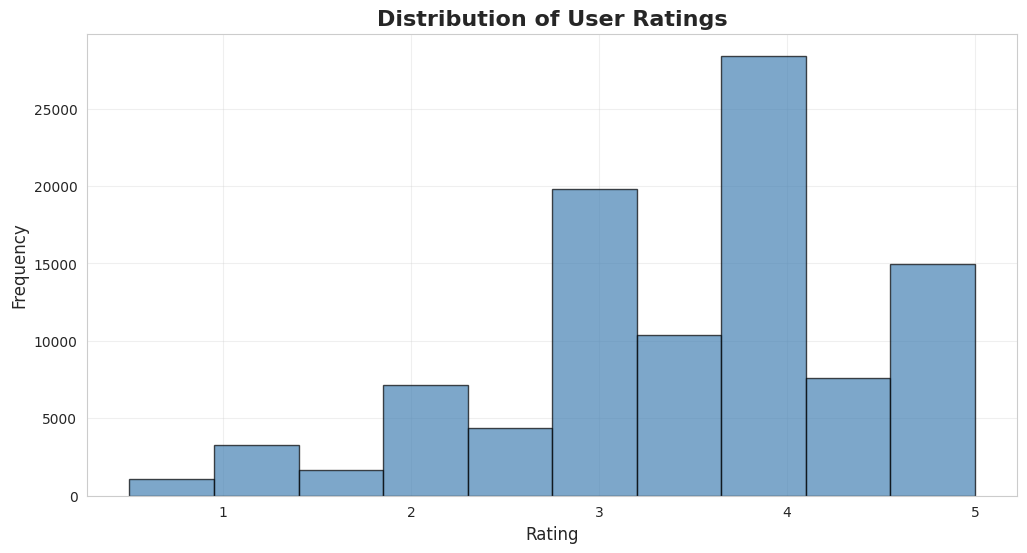

In [52]:
# Rating Distribution
plt.figure(figsize=(12, 6))
ratings_pd = ratings.select("rating").toPandas()
plt.hist(ratings_pd['rating'], bins=10, edgecolor='black', alpha=0.7, color='steelblue')
plt.title('Distribution of User Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

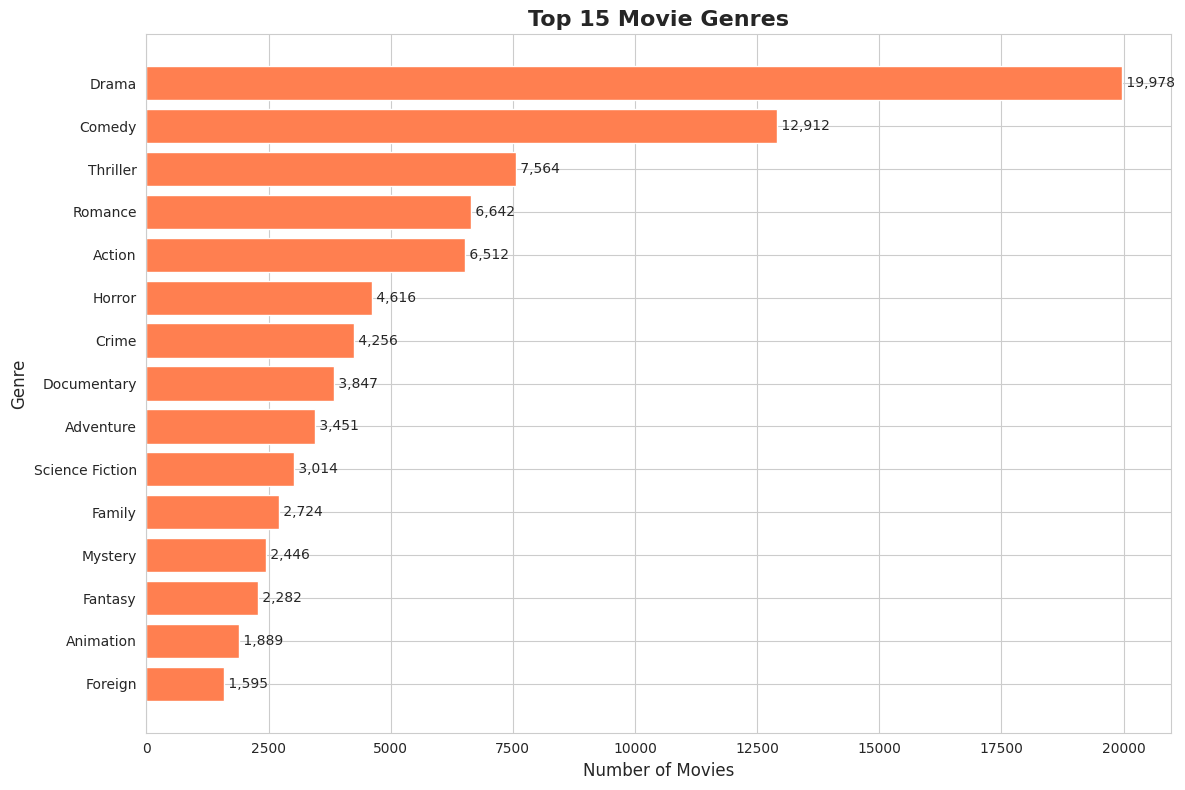

In [53]:
# Genre Distribution
genre_counts_pd = genre_counts.limit(15).toPandas()
plt.figure(figsize=(12, 8))
plt.barh(genre_counts_pd['genre'], genre_counts_pd['count'], color='coral')
plt.title('Top 15 Movie Genres', fontsize=16, fontweight='bold')
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.gca().invert_yaxis()
for i, v in enumerate(genre_counts_pd['count']):
    plt.text(v, i, f' {v:,}', va='center')
plt.tight_layout()
plt.show()

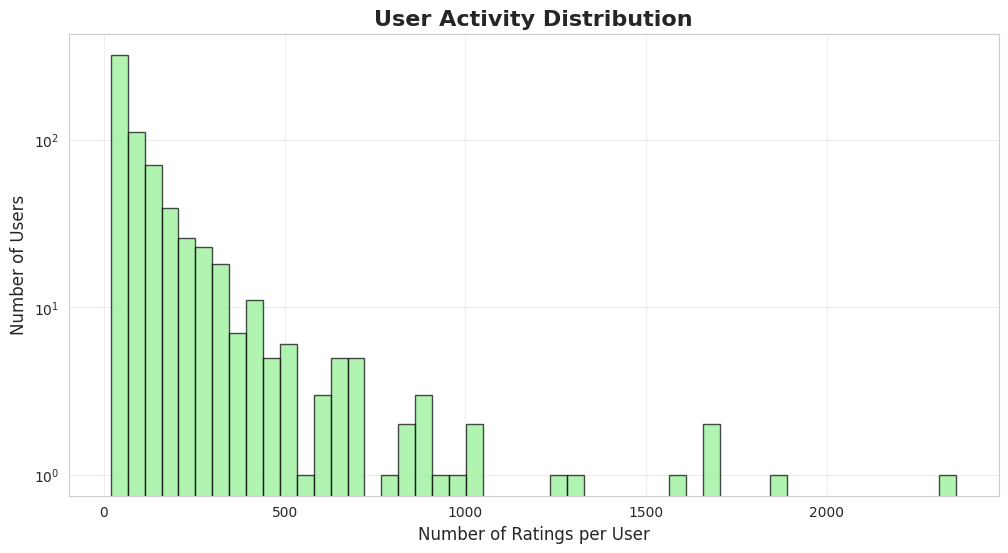

In [54]:
# User Activity Distribution
user_activity = user_stats.select("num_ratings").toPandas()
plt.figure(figsize=(12, 6))
plt.hist(user_activity['num_ratings'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('User Activity Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Number of Ratings per User', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.yscale('log')
plt.grid(alpha=0.3)
plt.show()

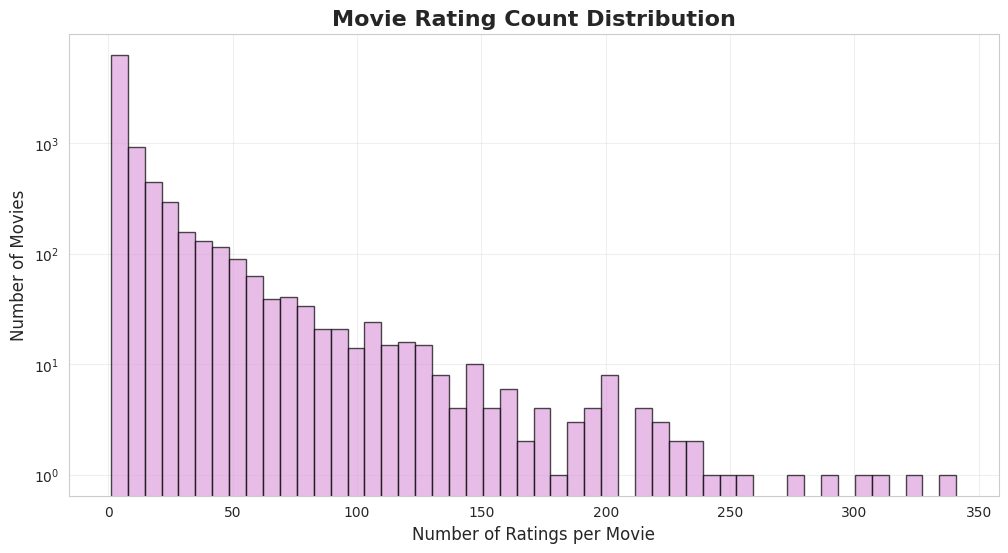

In [55]:
# Movie Rating Distribution
movie_activity = movie_stats.select("num_ratings").toPandas()
plt.figure(figsize=(12, 6))
plt.hist(movie_activity['num_ratings'], bins=50, edgecolor='black', alpha=0.7, color='plum')
plt.title('Movie Rating Count Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Number of Ratings per Movie', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.yscale('log')
plt.grid(alpha=0.3)
plt.show()

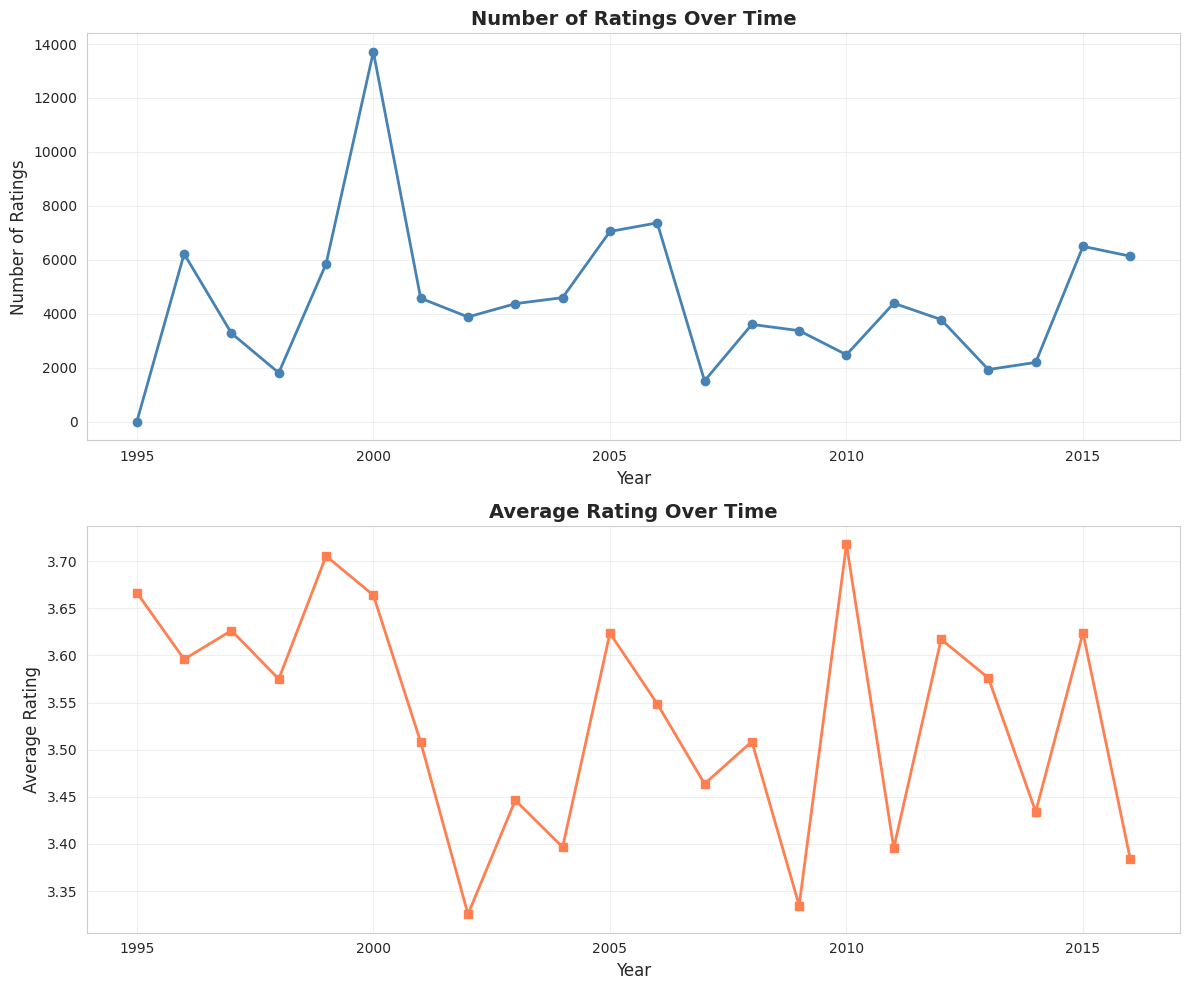

In [56]:
# Temporal Trends
yearly_pd = yearly_ratings.toPandas()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(yearly_pd['rating_year'], yearly_pd['num_ratings'], marker='o', linewidth=2, color='steelblue')
ax1.set_title('Number of Ratings Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Ratings', fontsize=12)
ax1.grid(alpha=0.3)

ax2.plot(yearly_pd['rating_year'], yearly_pd['avg_rating'], marker='s', linewidth=2, color='coral')
ax2.set_title('Average Rating Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Average Rating', fontsize=12)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

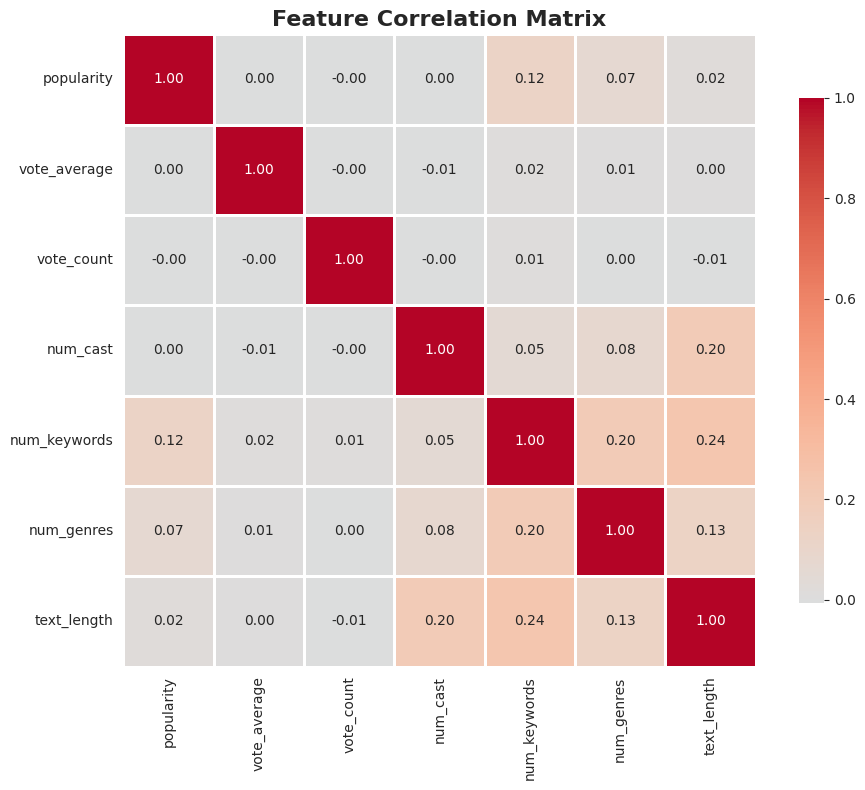

In [57]:
# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

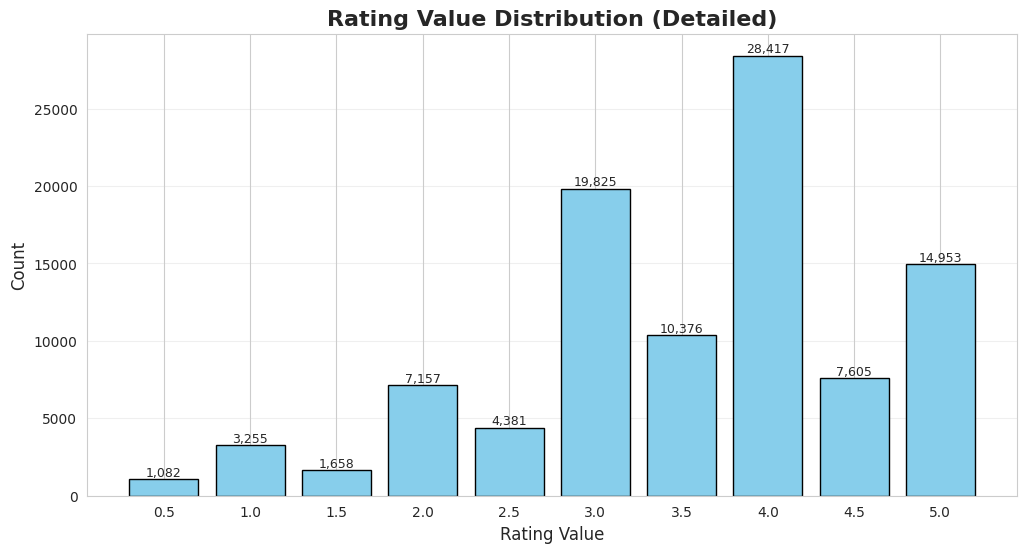

In [58]:
# Rating Value Distribution (Detailed)
rating_dist_pd = rating_dist.toPandas()
plt.figure(figsize=(12, 6))
bars = plt.bar(rating_dist_pd['rating'], rating_dist_pd['count'],
               color='skyblue', edgecolor='black', width=0.4)
plt.title('Rating Value Distribution (Detailed)', fontsize=16, fontweight='bold')
plt.xlabel('Rating Value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rating_dist_pd['rating'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)
plt.grid(alpha=0.3, axis='y')
plt.show()

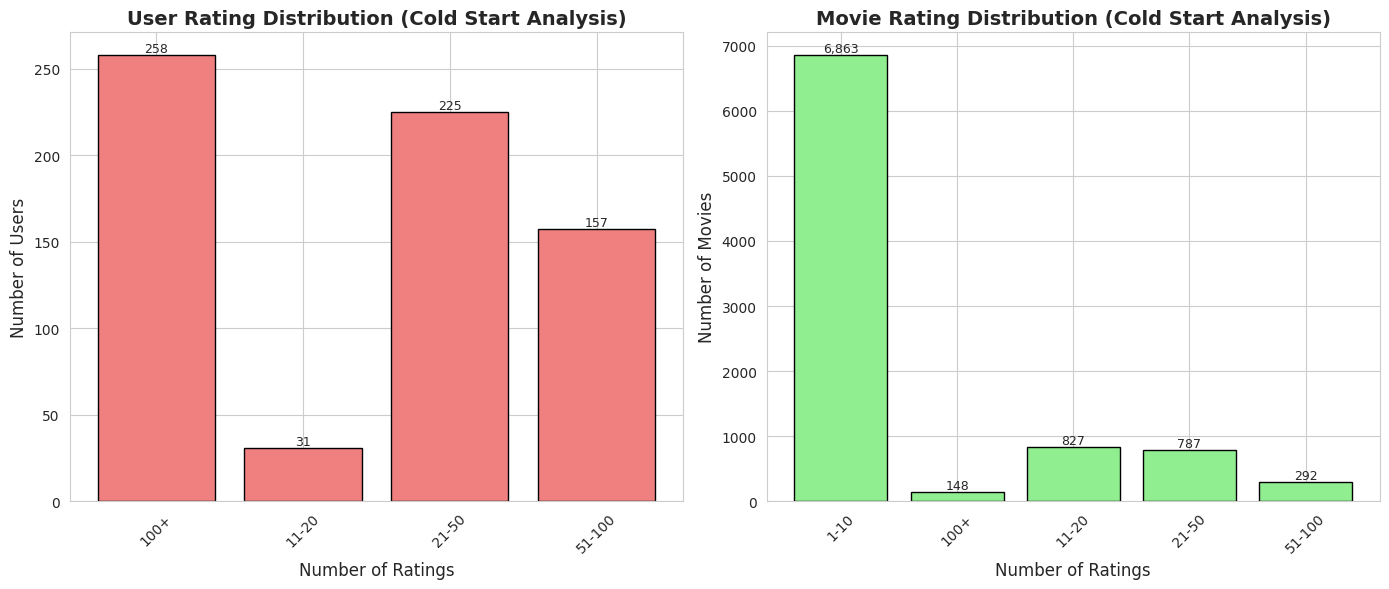

In [59]:
# Cold Start Analysis Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# User cold start
user_buckets_pd = user_rating_buckets.toPandas()
ax1.bar(user_buckets_pd['rating_bucket'], user_buckets_pd['count'],
        color='lightcoral', edgecolor='black')
ax1.set_title('User Rating Distribution (Cold Start Analysis)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Ratings', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(user_buckets_pd['count']):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Movie cold start
movie_buckets_pd = movie_rating_buckets.toPandas()
ax2.bar(movie_buckets_pd['rating_bucket'], movie_buckets_pd['count'],
        color='lightgreen', edgecolor='black')
ax2.set_title('Movie Rating Distribution (Cold Start Analysis)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Ratings', fontsize=12)
ax2.set_ylabel('Number of Movies', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(movie_buckets_pd['count']):
    ax2.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

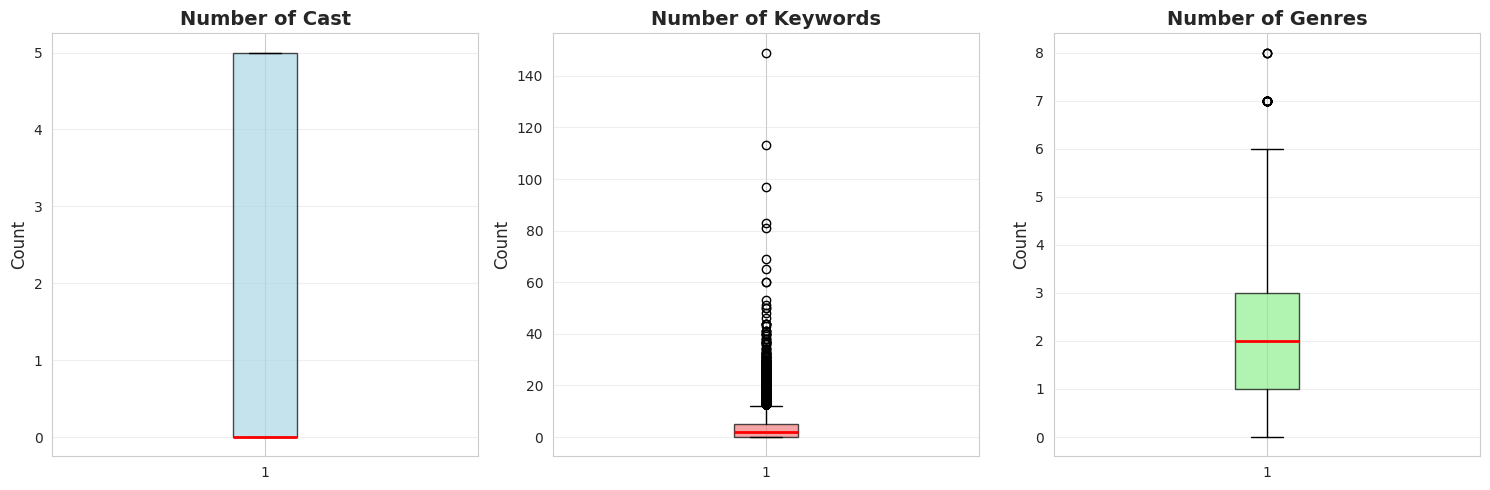

In [60]:
# Feature Statistics Box Plot
feature_data = movies_full.select(
    "num_cast", "num_keywords", "num_genres"
).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
features = ['num_cast', 'num_keywords', 'num_genres']
titles = ['Number of Cast', 'Number of Keywords', 'Number of Genres']
colors = ['lightblue', 'lightcoral', 'lightgreen']

for ax, feature, title, color in zip(axes, features, titles, colors):
    ax.boxplot(feature_data[feature], vert=True, patch_artist=True,
               boxprops=dict(facecolor=color, alpha=0.7),
               medianprops=dict(color='red', linewidth=2))
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## **Step 7: Models**

In [61]:
# Content-Based Filtering Implementation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

print("Building Content-Based Recommendation System")


movies_pd = movies_full.select(
    "movieId", "title", "overview",
    "vote_average", "vote_count", "popularity",
    "combined_text",
    "genres_str"
).toPandas()


# Key optimization: Only select popular movies with sufficient votes
# This reduces computational load and avoids memory overflow
min_votes = 50  # At least 50 votes
movies_pd = movies_pd[movies_pd['vote_count'] >= min_votes].reset_index(drop=True)

print(f"Filtered to {len(movies_pd)} movies with at least {min_votes} votes")

# TF-IDF vectorization
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=3000,  # Reduce feature count (from 5000 to 3000)
    min_df=2,           # Ignore rare terms
    max_df=0.8          # Ignore too frequent terms
)

tfidf_matrix = tfidf.fit_transform(movies_pd['combined_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Compute similarity matrix in chunks to avoid memory overflow
chunk_size = 500  # Process 500 movies at a time
n_movies = tfidf_matrix.shape[0]
n_chunks = (n_movies + chunk_size - 1) // chunk_size

print(f"\nComputing cosine similarity in {n_chunks} chunks...")

# Initialize similarity matrix
cosine_sim = np.zeros((n_movies, n_movies), dtype=np.float32)  # Use float32 to save memory

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, n_movies)

    # Compute similarity between current chunk and all movies
    chunk_sim = cosine_similarity(
        tfidf_matrix[start_idx:end_idx],
        tfidf_matrix
    )

    # Store results
    cosine_sim[start_idx:end_idx, :] = chunk_sim

    if (i + 1) % 5 == 0:
        print(f"  Processed chunk {i+1}/{n_chunks}")

print(f"Cosine similarity matrix completed: {cosine_sim.shape}")

# Create index mapping
indices = pd.Series(movies_pd.index, index=movies_pd['title']).drop_duplicates()

print(f"Created index mapping for {len(indices)} unique movie titles")


# Recommendation function remains unchanged
def get_content_recommendations(title, cosine_sim=cosine_sim, top_n=10):
    """
    Get movie recommendations based on content similarity
    """
    try:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]

        movie_indices = [i[0] for i in sim_scores]
        recommendations = movies_pd.iloc[movie_indices][['title', 'movieId', 'vote_average', 'popularity']].copy()
        recommendations['similarity_score'] = [i[1] for i in sim_scores]

        return recommendations

    except KeyError:
        return f"Movie '{title}' not found in dataset"


# Test
print("\nTesting Content-Based Recommendations:")

test_movie = 'Toy Story'
recommendations = get_content_recommendations(test_movie, top_n=5)

print(f"\nTop 5 movies similar to '{test_movie}':\n")
if isinstance(recommendations, pd.DataFrame):
    print(recommendations.to_string(index=False))
else:
    print(recommendations)

Building Content-Based Recommendation System
Filtered to 8575 movies with at least 50 votes
TF-IDF matrix shape: (8575, 3000)

Computing cosine similarity in 18 chunks...
  Processed chunk 5/18
  Processed chunk 10/18
  Processed chunk 15/18
Cosine similarity matrix completed: (8575, 8575)
Created index mapping for 8575 unique movie titles

Testing Content-Based Recommendations:

Top 5 movies similar to 'Toy Story':

                 title  movieId  vote_average  popularity  similarity_score
           Toy Story 2     3114           7.3   17.547693          0.527600
           Toy Story 3    78499           7.6   16.966470          0.512870
        Small Soldiers     1920           6.2   10.039360          0.357311
The 40 Year Old Virgin    35836           6.2   11.519662          0.319531
       Partysaurus Rex   120468           7.4    6.066171          0.310149


In [62]:
# Collaborative Filtering Implementation
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

print("Building Collaborative Filtering System")

# Split data into training and test sets (80-20 split)
(training, test) = ratings.randomSplit([0.8, 0.2], seed=42)

print(f"\nTraining set size: {training.count():,} ratings")
print(f"Test set size: {test.count():,} ratings")

# Initialize ALS model
als = ALS(
    maxIter=10,              # Number of iterations
    regParam=0.1,            # Regularization parameter
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop", # Handle cold start
    nonnegative=True         # Non-negative factors
)

# Train the model
print("\nTraining ALS model (this may take a few minutes)...")
als_model = als.fit(training)

print("Model training completed!")

# Make predictions on test set
print("\nEvaluating model performance...")
predictions = als_model.transform(test)

# Show sample predictions
print("\nSample predictions:")
predictions.select("userId", "movieId", "rating", "prediction").show(5)

# Evaluate using RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)

# Calculate MAE
mae = evaluator.setMetricName("mae").evaluate(predictions)

print("Collaborative Filtering Performance Metrics:")
print(f"RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error):     {mae:.4f}")

# Interpretation
if rmse < 1.0:
    print("Good performance! RMSE < 1.0")
else:
    print("Consider tuning hyperparameters for better results")


def get_collaborative_recommendations(user_id, n_recommendations=10):
    """
    Generate movie recommendations for a specific user
    """
    user_df = spark.createDataFrame([(user_id,)], ["userId"])
    user_recs = als_model.recommendForUserSubset(user_df, n_recommendations)
    return user_recs


# Test collaborative filtering
print("\n\nTesting Collaborative Filtering:")
print("="*60)

test_user_id = 1

# Show user's history first
print(f"\nUser {test_user_id}'s Top Rated Movies:")
user_history = ratings.filter(F.col("userId") == test_user_id) \
    .join(movies_full.select("movieId", "title", "vote_average"), on="movieId") \
    .select("title", "rating", "vote_average") \
    .orderBy(F.desc("rating")) \
    .limit(10)

user_history.show(10, truncate=False)

# Generate recommendations
user_recs = get_collaborative_recommendations(test_user_id, n_recommendations=5)

print(f"\nTop 5 recommended movies for User {test_user_id}:")
user_recs.show(truncate=False)

# Save the trained model
print("\nSaving ALS model...")
als_model.write().overwrite().save(f"{CLEAN_PATH}/als_model")
print(f"Model saved to: {CLEAN_PATH}/als_model")

Building Collaborative Filtering System

Training set size: 79,047 ratings
Test set size: 19,662 ratings

Training ALS model (this may take a few minutes)...
Model training completed!

Evaluating model performance...

Sample predictions:
+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|    13|      1|   5.0| 3.6204472|
|    23|      1|   3.0| 3.9268885|
|    30|      1|   4.0|  4.107923|
|    48|      1|   4.0| 3.6471424|
|    69|      1|   5.0|  4.388494|
+------+-------+------+----------+
only showing top 5 rows

Collaborative Filtering Performance Metrics:
RMSE (Root Mean Square Error): 0.9046
MAE (Mean Absolute Error):     0.7050
Good performance! RMSE < 1.0


Testing Collaborative Filtering:

User 1's Top Rated Movies:
+-----------------------------------------------------------------------------------+------+------------+
|title                                                                              |rating|vote_averag

In [63]:
# Model Comparison and Evaluation
print("Model Comparison and Analysis")

# Calculate diversity for content-based
def calculate_diversity(recommendations, cosine_sim):
    """
    Calculate recommendation diversity
    Higher diversity = more varied recommendations
    """
    if len(recommendations) < 2:
        return 0

    diversity_scores = []

    for i in range(len(recommendations)):
        for j in range(i+1, len(recommendations)):
            try:
                idx_i = indices[recommendations.iloc[i]['title']]
                idx_j = indices[recommendations.iloc[j]['title']]
                dissimilarity = 1 - cosine_sim[idx_i][idx_j]
                diversity_scores.append(dissimilarity)
            except:
                continue

    return np.mean(diversity_scores) if diversity_scores else 0


# Analyze content-based recommendations
toy_story_recs = get_content_recommendations('Toy Story', top_n=10)
diversity_score = calculate_diversity(toy_story_recs, cosine_sim)

print("\nContent-Based Filtering Analysis:")
print(f"Test Movie: 'Toy Story'")
print(f"Number of recommendations: {len(toy_story_recs)}")
print(f"Average similarity score: {toy_story_recs['similarity_score'].mean():.4f}")
print(f"Diversity score: {diversity_score:.4f}")
print("\nPros:")
print("  ✓ No cold start problem - works for new users")
print("  ✓ Interpretable - we know WHY a movie is recommended")
print("  ✓ No data privacy concerns")
print("  ✓ Fast - pre-computed similarities")
print("\nCons:")
print("  ✗ Limited serendipity - only recommends similar content")
print("  ✗ Filter bubble effect - can't discover new genres")
print("  ✗ Requires rich item metadata")

print("\n" + "="*80)

print("\nCollaborative Filtering Analysis:")
print("-" * 80)
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"Training set: {training.count():,} ratings")
print(f"Test set: {test.count():,} ratings")
print("\nPros:")
print("  ✓ Can discover new interests - recommends unexpected items")
print("  ✓ No need for item metadata")
print("  ✓ Learns from collective intelligence")
print("  ✓ Handles implicit preferences")
print("\nCons:")
print("  ✗ Cold start problem - needs user history")
print("  ✗ Data sparsity issues")
print("  ✗ Less interpretable")


# Performance comparison table
print("\nPerformance Comparison Summary:")
print("-" * 80)
print(f"{'Metric':<35} {'Content-Based':<20} {'Collaborative':<20}")
print("-" * 80)
print(f"{'Cold Start Handling':<35} {'✓ Excellent':<20} {'✗ Poor':<20}")
print(f"{'Diversity Score':<35} {f'{diversity_score:.4f}':<20} {'N/A':<20}")
print(f"{'Prediction Accuracy (RMSE)':<35} {'N/A':<20} {f'{rmse:.4f}':<20}")
print(f"{'Prediction Accuracy (MAE)':<35} {'N/A':<20} {f'{mae:.4f}':<20}")
print(f"{'Interpretability':<35} {'✓ High':<20} {'✗ Low':<20}")
print(f"{'Scalability (via Spark)':<35} {'✓ Good':<20} {'✓ Excellent':<20}")
print(f"{'Computational Speed':<35} {'✓ Fast':<20} {'△ Moderate':<20}")
print("-" * 80)

# Additional statistics
print("\nDataset Statistics:")
print("-" * 80)
print(f"Total Movies: {movies_pd.shape[0]:,}")
print(f"Total Ratings: {ratings.count():,}")
print(f"Total Users: {ratings.select('userId').distinct().count():,}")
print(f"Average Rating: {ratings.agg({'rating': 'avg'}).collect()[0][0]:.2f}")
print(f"Data Sparsity: {(1 - ratings.count() / (ratings.select('userId').distinct().count() * ratings.select('movieId').distinct().count())) * 100:.2f}%")

Model Comparison and Analysis

Content-Based Filtering Analysis:
Test Movie: 'Toy Story'
Number of recommendations: 10
Average similarity score: 0.3367
Diversity score: 0.7586

Pros:
  ✓ No cold start problem - works for new users
  ✓ Interpretable - we know WHY a movie is recommended
  ✓ No data privacy concerns
  ✓ Fast - pre-computed similarities

Cons:
  ✗ Limited serendipity - only recommends similar content
  ✗ Filter bubble effect - can't discover new genres
  ✗ Requires rich item metadata


Collaborative Filtering Analysis:
--------------------------------------------------------------------------------
RMSE: 0.9046
MAE:  0.7050
Training set: 79,047 ratings
Test set: 19,662 ratings

Pros:
  ✓ Can discover new interests - recommends unexpected items
  ✓ No need for item metadata
  ✓ Learns from collective intelligence
  ✓ Handles implicit preferences

Cons:
  ✗ Cold start problem - needs user history
  ✗ Data sparsity issues
  ✗ Less interpretable

Performance Comparison Summary

In [64]:
# Save All Results and Models
import pickle

# Save TF-IDF model and matrix (for Streamlit app)
print("Saving TF-IDF components...")
with open(f"{CLEAN_PATH}/tfidf_model.pkl", "wb") as f:
    pickle.dump(tfidf, f)
print("Saved: tfidf_model.pkl")

with open(f"{CLEAN_PATH}/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)
print("Saved: tfidf_matrix.pkl")

# Save cosine similarity matrix
print("\nSaving similarity matrix...")
with open(f"{CLEAN_PATH}/cosine_sim.pkl", "wb") as f:
    pickle.dump(cosine_sim, f)
print("Saved: cosine_sim.pkl")

# Save movie title index mapping
with open(f"{CLEAN_PATH}/indices.pkl", "wb") as f:
    pickle.dump(indices, f)
print("Saved: indices.pkl")

# Save movies dataframe (Pandas format for Streamlit)
print("\nSaving movies dataframe...")
movies_pd.to_parquet(f"{CLEAN_PATH}/movies_pd.parquet")
print("Saved: movies_pd.parquet")

# Save performance metrics
metrics_dict = {
    'rmse': rmse,
    'mae': mae,
    'diversity_score': diversity_score,
    'n_training': training.count(),
    'n_test': test.count(),
    'avg_similarity': toy_story_recs['similarity_score'].mean()
}

with open(f"{CLEAN_PATH}/metrics.pkl", "wb") as f:
    pickle.dump(metrics_dict, f)
print("Saved: metrics.pkl")

print(f"\n📂 Saved location: {CLEAN_PATH}")
print("\n📁 Files created:")
print("  • movies_full/           - Cleaned movie data (Parquet)")
print("  • ratings/               - Cleaned ratings data (Parquet)")
print("  • tfidf_features/        - TF-IDF vectors (Parquet)")
print("  • als_model/             - Trained ALS model")
print("  • tfidf_model.pkl        - TF-IDF vectorizer")
print("  • tfidf_matrix.pkl       - TF-IDF feature matrix")
print("  • cosine_sim.pkl         - Cosine similarity matrix")
print("  • indices.pkl            - Movie title to index mapping")
print("  • movies_pd.parquet      - Movies dataframe (Pandas)")
print("  • metrics.pkl            - Performance metrics")

Saving TF-IDF components...
Saved: tfidf_model.pkl
Saved: tfidf_matrix.pkl

Saving similarity matrix...
Saved: cosine_sim.pkl
Saved: indices.pkl

Saving movies dataframe...
Saved: movies_pd.parquet
Saved: metrics.pkl

📂 Saved location: /content/drive/MyDrive/movie-reco/clean

📁 Files created:
  • movies_full/           - Cleaned movie data (Parquet)
  • ratings/               - Cleaned ratings data (Parquet)
  • tfidf_features/        - TF-IDF vectors (Parquet)
  • als_model/             - Trained ALS model
  • tfidf_model.pkl        - TF-IDF vectorizer
  • tfidf_matrix.pkl       - TF-IDF feature matrix
  • cosine_sim.pkl         - Cosine similarity matrix
  • indices.pkl            - Movie title to index mapping
  • movies_pd.parquet      - Movies dataframe (Pandas)
  • metrics.pkl            - Performance metrics


In [65]:
# Save All Results and Models
import pickle

print("Saving models and data...")

print("\nSaving FULL movies dataframe for ALS...")
movies_pd_full = movies_full.select(
    "movieId", "title", "overview",
    "vote_average", "vote_count", "popularity",
    "combined_text",
    "genres_str"
).toPandas()

movies_pd_full.to_parquet(f"{CLEAN_PATH}/movies_pd_full.parquet")
print(f"Saved: movies_pd_full.parquet ({len(movies_pd_full):,} movies)")

movies_pd.to_parquet(f"{CLEAN_PATH}/movies_pd_content.parquet")
print(f"Saved: movies_pd_content.parquet ({len(movies_pd):,} movies)")

# movies_pd.parquet
movies_pd_full.to_parquet(f"{CLEAN_PATH}/movies_pd.parquet")
print("Saved: movies_pd.parquet (full version for backward compatibility)")

# ============ 继续保存其他模型 ============

# Save TF-IDF model and matrix
print("\nSaving TF-IDF components...")
with open(f"{CLEAN_PATH}/tfidf_model.pkl", "wb") as f:
    pickle.dump(tfidf, f)
print("Saved: tfidf_model.pkl")

with open(f"{CLEAN_PATH}/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)
print("Saved: tfidf_matrix.pkl")

# Save cosine similarity matrix
print("\nSaving similarity matrix...")
with open(f"{CLEAN_PATH}/cosine_sim.pkl", "wb") as f:
    pickle.dump(cosine_sim, f)
print("Saved: cosine_sim.pkl")

# Save movie title index mapping
with open(f"{CLEAN_PATH}/indices.pkl", "wb") as f:
    pickle.dump(indices, f)
print("Saved: indices.pkl")

# Save performance metrics
metrics_dict = {
    'rmse': rmse,
    'mae': mae,
    'diversity_score': diversity_score,
    'n_training': training.count(),
    'n_test': test.count(),
    'avg_similarity': toy_story_recs['similarity_score'].mean(),
    'n_movies_full': len(movies_pd_full),
    'n_movies_content': len(movies_pd)
}

with open(f"{CLEAN_PATH}/metrics.pkl", "wb") as f:
    pickle.dump(metrics_dict, f)
print("Saved: metrics.pkl")

print(f"\n All files saved to: {CLEAN_PATH}")
print("\n Key fix: Saved both full and filtered movie datasets")
print(f"   • movies_pd_full.parquet: {len(movies_pd_full):,} movies (for ALS)")
print(f"   • movies_pd_content.parquet: {len(movies_pd):,} movies (for Content-Based)")

Saving models and data...

Saving FULL movies dataframe for ALS...
Saved: movies_pd_full.parquet (44,706 movies)
Saved: movies_pd_content.parquet (8,575 movies)
Saved: movies_pd.parquet (full version for backward compatibility)

Saving TF-IDF components...
Saved: tfidf_model.pkl
Saved: tfidf_matrix.pkl

Saving similarity matrix...
Saved: cosine_sim.pkl
Saved: indices.pkl
Saved: metrics.pkl

 All files saved to: /content/drive/MyDrive/movie-reco/clean

 Key fix: Saved both full and filtered movie datasets
   • movies_pd_full.parquet: 44,706 movies (for ALS)
   • movies_pd_content.parquet: 8,575 movies (for Content-Based)


## **Step 8: Streamlit Web Application**

In [66]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
!pip install streamlit pyngrok

In [68]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle
import altair as alt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALSModel
from pyspark.sql.functions import count as F_count, avg as F_avg, desc as F_desc

import altair as alt

# Same cleaned data path as in your notebook
CLEAN_PATH = "/content/drive/MyDrive/movie-reco/clean"

# ====================== Spark & Data Loading ======================

@st.cache_resource
def get_spark():
    return SparkSession.builder.appName("MovieRecApp").getOrCreate()

@st.cache_data
def load_content_models():
    # Load files required for content-based filtering
    with open(f"{CLEAN_PATH}/cosine_sim.pkl", "rb") as f:
        cosine_sim = pickle.load(f)
    with open(f"{CLEAN_PATH}/indices.pkl", "rb") as f:
        indices = pickle.load(f)
    movies_pd = pd.read_parquet(f"{CLEAN_PATH}/movies_pd.parquet")
    return cosine_sim, indices, movies_pd

@st.cache_resource
def load_als_model():
    spark = get_spark()
    als_model = ALSModel.load(f"{CLEAN_PATH}/als_model")
    ratings = spark.read.parquet(f"{CLEAN_PATH}/ratings")
    return als_model, ratings

@st.cache_data
def prepare_scatter_data(movies_pd):
    df = movies_pd[['movieId', 'title', 'vote_count', 'vote_average', 'popularity']].copy()
    df = df.dropna()
    df = df[df['vote_count'] > 0]

    # Keep only valid vote_average values between 0–10
    df = df[(df['vote_average'] >= 0) & (df['vote_average'] <= 10)]

    # Remove top 1% extreme values in vote_count
    upper = df['vote_count'].quantile(0.99)
    df = df[df['vote_count'] <= upper]

    return df

# ====================== Recommendation Functions ======================

def get_content_recommendations(title, cosine_sim, indices, movies_pd, top_n=10):
    """Return content-based recommendations, flattening similarity row into 1D vector."""
    # Ignore tags like #Horror
    if str(title).startswith("#"):
        return None

    try:
        idx = indices[title]
    except KeyError:
        return None

    row = cosine_sim[idx]

    if hasattr(row, "toarray"):
        row = row.toarray()

    if hasattr(row, "values"):
        row = row.values

    row = np.array(row).ravel()

    sim_scores = list(enumerate(row))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    recs = movies_pd.iloc[movie_indices][['title', 'movieId', 'vote_average', 'popularity']].copy()
    recs['similarity_score'] = [i[1] for i in sim_scores]
    return recs

def get_collaborative_recommendations(user_id, n_recommendations=10):
    spark = get_spark()
    als_model, _ = load_als_model()
    user_df = spark.createDataFrame([(int(user_id),)], ["userId"])
    user_recs = als_model.recommendForUserSubset(user_df, n_recommendations)

    from pyspark.sql.functions import explode
    exploded = user_recs.select("userId", explode("recommendations").alias("rec"))
    exploded = exploded.select(
        "userId",
        exploded.rec.movieId.alias("movieId"),
        exploded.rec.rating.alias("pred_rating")
    )
    return exploded.toPandas()

def build_highlight_scatter(scatter_df, movies_pd, movie_title, recs):
    """
    Build scatter plot highlighting:
    - Selected Movie
    - Recommended Movie
    - Other
    And overlay text labels for selected/recommended movies.
    """
    plot_df = scatter_df.copy()
    plot_df["highlight"] = "Other"

    # Selected movie
    try:
        sel_id = int(movies_pd.loc[movies_pd["title"] == movie_title, "movieId"].iloc[0])
    except IndexError:
        sel_id = None

    if sel_id is not None:
        plot_df.loc[plot_df["movieId"] == sel_id, "highlight"] = "Selected Movie"

    # Recommended movies
    if recs is not None and len(recs) > 0:
        rec_ids = set(recs["movieId"].astype(int).tolist())
        plot_df.loc[plot_df["movieId"].isin(rec_ids), "highlight"] = "Recommended Movie"

    label_df = plot_df[plot_df["highlight"] != "Other"]

    x_zoom = alt.selection_interval(bind="scales", encodings=["x"])

    points = (
        alt.Chart(plot_df)
        .mark_circle(size=30, opacity=0.35)
        .encode(
            x=alt.X("vote_count", title="Vote Count"),
            y=alt.Y("vote_average", title="Average Rating", scale=alt.Scale(domain=(0, 10))),
            color=alt.Color(
                "highlight",
                title="Legend",
                scale=alt.Scale(
                    domain=["Selected Movie", "Recommended Movie", "Other"],
                    range=["red", "orange", "lightgray"],
                ),
            ),
            tooltip=["title", "vote_count", "vote_average", "popularity", "highlight"],
        )
    )

    labels = (
        alt.Chart(label_df)
        .mark_text(dx=5, dy=-5, fontSize=11)
        .encode(
            x="vote_count",
            y="vote_average",
            text="title",
            color=alt.Color(
                "highlight",
                scale=alt.Scale(
                    domain=["Selected Movie", "Recommended Movie"],
                    range=["red", "orange"],
                ),
                legend=None,
            ),
        )
    )

    chart = (points + labels).add_selection(x_zoom)
    return chart

@st.cache_data
def get_user_summary():
    """Select active users for dropdown."""
    spark = get_spark()
    _, ratings = load_als_model()

    user_stats = (
        ratings.groupBy("userId")
        .agg(
            F_count("*").alias("num_ratings"),
            F_avg("rating").alias("avg_rating")
        )
    )

    top_users = user_stats.orderBy(F_desc("num_ratings")).limit(50).toPandas()
    top_users["label"] = top_users.apply(
        lambda r: f"User {int(r.userId)}  (ratings={int(r.num_ratings)}, avg={r.avg_rating:.2f})",
        axis=1
    )
    return top_users

def get_user_profile_movies(user_id, movies_pd, top_k=10):
    """User profile: movie favorites based on rating history."""
    spark = get_spark()
    _, ratings = load_als_model()
    from pyspark.sql.functions import col

    user_ratings = (
        ratings.filter(col("userId") == int(user_id))
        .orderBy(col("rating").desc())
        .limit(top_k * 3)
        .toPandas()
    )

    if user_ratings.empty:
        return user_ratings

    user_ratings["movieId"] = user_ratings["movieId"].astype(int)

    movies_cols = ["movieId", "title"]
    if "genres_str" in movies_pd.columns:
        movies_cols.append("genres_str")

    movies_pd_local = movies_pd[movies_cols].copy()
    movies_pd_local["movieId"] = movies_pd_local["movieId"].astype(int)

    merged = user_ratings.merge(
        movies_pd_local,
        on="movieId",
        how="left"
    )

    merged = merged[merged["title"].notna()].copy()

    if "genres_str" in merged.columns:
        merged = merged.rename(columns={"genres_str": "tags"})
    else:
        merged["tags"] = ""

    merged = merged.head(top_k)
    return merged[["movieId", "title", "tags", "rating"]]


# ====================== Streamlit UI ======================

st.set_page_config(page_title="Movie Recommender", layout="wide")
st.title(" Movie Recommendation System")

st.markdown("""
Welcome to the **Movie Recommendation System**

This web app demonstrates two recommendation approaches built in the Big Data course:

- **Content-based Recommendation**: Enter a movie to find similar ones (TF-IDF + Cosine Similarity)
- **Collaborative Filtering (ALS)**: Matrix factorization based on user rating history

 Start by selecting a movie and see what the system recommends.
""")

# Load models and movie data
cosine_sim, indices, movies_pd = load_content_models()

# Movie list (remove tags starting with #)
all_titles = movies_pd["title"].dropna().unique()
all_titles = sorted([t for t in all_titles if not str(t).startswith("#")])
scatter_df = prepare_scatter_data(movies_pd)

# Tabs
tab1, tab2 = st.tabs([" Content-Based Recommendation", " Collaborative Filtering (ALS)"])

with tab1:
    st.subheader(" Find Similar Movies (Content-based)")

    search_query = st.text_input("Enter movie name (supports fuzzy search):", value="")

    if search_query:
        filtered_titles = [t for t in all_titles if search_query.lower() in t.lower()]
        if not filtered_titles:
            st.warning("No matches found. Showing all movies.")
            filtered_titles = all_titles
    else:
        filtered_titles = all_titles

    movie_title = st.selectbox(
        "Select a movie from the search results:",
        options=filtered_titles,
    )

    top_n = st.slider("Number of recommendations", 5, 20, 10)

    if st.button(" Get Similar Movies", key="btn_content"):
        recs = get_content_recommendations(movie_title, cosine_sim, indices, movies_pd, top_n=top_n)
        if recs is None or len(recs) == 0:
            st.warning("Movie not found in model index or no similar results.")
        else:
            recs = recs.sort_values("similarity_score", ascending=False).reset_index(drop=True)

            recs.index = recs.index +1
            st.success(f"Movies similar to **{movie_title}**:")
            st.dataframe(recs)

            chart = build_highlight_scatter(scatter_df, movies_pd, movie_title, recs)
            st.altair_chart(chart, use_container_width=True)

with tab2:
    st.subheader(" Recommend Movies Based on User Rating History (ALS)")

    top_users = get_user_summary()
    if top_users.empty:
        st.warning("No user statistics found.")
    else:
        user_label = st.selectbox(
            "Choose an example user profile:",
            options=top_users["label"].tolist()
        )

        user_id = int(
            top_users.loc[top_users["label"] == user_label, "userId"].iloc[0]
        )

        n_rec = st.slider("Number of recommendations", 5, 20, 10, key="als_slider")

        profile_df = get_user_profile_movies(user_id, movies_pd, top_k=10)
        if profile_df.empty:
            st.info("This user has no rating history.")
        else:
            profile_df = profile_df.reset_index(drop=True)
            profile_df.index = profile_df.index + 1
            st.markdown("###  User's Favorite Movies (Top 10 Rated)")
            st.dataframe(profile_df)

        if st.button(" Get ALS Recommendations", key="btn_als"):
            try:
                raw_n = n_rec * 8
                recs = get_collaborative_recommendations(user_id, n_recommendations=raw_n)
                if recs.empty:
                    st.warning("No recommendations returned (user may not exist in training set).")
                else:
                    recs["movieId"] = recs["movieId"].astype(int)

                    movies_cols = ["movieId", "title"]
                    if "genres_str" in movies_pd.columns:
                        movies_cols.append("genres_str")

                    movies_pd_local = movies_pd[movies_cols].copy()
                    movies_pd_local["movieId"] = movies_pd_local["movieId"].astype(int)

                    merged = recs.merge(
                        movies_pd_local,
                        on="movieId",
                        how="left"
                    )

                    total = len(merged)

                    merged = merged[merged["title"].notna()].copy()
                    kept = len(merged)
                    dropped = total - kept

                    if "genres_str" in merged.columns:
                        merged = merged.rename(columns={"genres_str": "tags"})
                    else:
                        merged["tags"] = ""

                    merged = merged.head(n_rec)


                    if merged.empty:
                        st.warning("None of the recommended movies have title metadata available.")
                    else:
                        merged = merged.sort_values("pred_rating", ascending=False).reset_index(drop=True)
                        merged["pred_rating"] = merged["pred_rating"].clip(lower=0, upper=5)
                        merged.index = merged.index + 1
                        st.markdown("###  ALS Recommended Movies (with Tags)")
                        st.dataframe(
                            merged[["userId", "movieId", "title", "tags", "pred_rating"]]
                        )
            except Exception as e:
                st.error(f"Error: {e}")


Overwriting app.py


In [69]:
!pkill -f streamlit || echo "no streamlit running"
!pkill -f ngrok || echo "no ngrok running"

^C
^C


In [70]:
!nohup streamlit run app.py --server.port 8501 &>/content/streamlit.log &

In [73]:
!sleep 5
!curl -I localhost:8501 || echo "no response from 8501"

HTTP/1.1 200 OK
Server: TornadoServer/6.5.1
Content-Type: text/html
Date: Tue, 09 Dec 2025 21:13:20 GMT
Accept-Ranges: bytes
Etag: "aae97bbcf069860f92fc43a08fd3757ac4c7f24b0657acfaef7f11f1f668fde2a8a9a024108a3a174b45c3feaee0290cf045529cbb8031ae827379420591a49d"
Last-Modified: Tue, 09 Dec 2025 19:46:41 GMT
Cache-Control: no-cache
Content-Length: 1522
Vary: Accept-Encoding



In [72]:
from pyngrok import ngrok

ngrok.set_auth_token("35ngxZzCwyMtmn7TNsYvMPG1xcb_28SjLjjuFzxTeaCEPBSia")

public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://nonimbricated-acrobatically-kirstin.ngrok-free.dev" -> "http://localhost:8501">